In [1]:
import os
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [5]:
# Load CSV files
def load_data(file_path):
    return pd.read_csv(file_path, compression='gzip')

# Define file paths
os.chdir("C:/Users/曾雪竹/Desktop/SM2/ST5230/mimic-iv-note-2.2/mimic-iv-note-2.2")

discharge_file = './discharge.csv.gz'
discharge_detail_file = './discharge_detail.csv.gz'
radiology_file = './radiology.csv.gz'
radiology_detail_file = './radiology_detail.csv.gz'

# Load datasets
discharge_df = load_data(discharge_file)
radiology_df = load_data(radiology_file)


In [7]:
print(discharge_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331793 entries, 0 to 331792
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   note_id     331793 non-null  object
 1   subject_id  331793 non-null  int64 
 2   hadm_id     331793 non-null  int64 
 3   note_type   331793 non-null  object
 4   note_seq    331793 non-null  int64 
 5   charttime   331793 non-null  object
 6   storetime   331776 non-null  object
 7   text        331793 non-null  object
dtypes: int64(3), object(5)
memory usage: 20.3+ MB
None


In [9]:
print(radiology_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321355 entries, 0 to 2321354
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   note_id     object 
 1   subject_id  int64  
 2   hadm_id     float64
 3   note_type   object 
 4   note_seq    int64  
 5   charttime   object 
 6   storetime   object 
 7   text        object 
dtypes: float64(1), int64(2), object(5)
memory usage: 141.7+ MB
None


In [37]:
subset_dis_df = discharge_df.sample(n=10000, random_state=42)  # 抽取 10,000 行
subset_rad_df = radiology_df.sample(n=10000, random_state=42)  # 抽取 10,000 行

# Extract text columns (assuming 'text' is the main content column)
discharge_texts = subset_dis_df['text'].dropna().tolist()
radiology_texts = subset_rad_df['text'].dropna().tolist()

# Merge text data
all_texts = discharge_texts + radiology_texts



In [39]:
# Sample Preprocessing Function
def preprocess_text(texts):
    processed_texts = [gensim.utils.simple_preprocess(doc) for doc in texts]
    return processed_texts

In [41]:
tokenized_data = preprocess_text(all_texts)

In [43]:
# Train a Word2Vec model
# The min_count parameter ensures words appearing less than 2 time are ignored
import time

start_time=time.time()
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=2, sg=1, workers=8)
end_time = time.time()

print(f"Word2Vec (Skip-gram) 训练时间: {end_time - start_time:.2f} 秒")

word2vec_model.save("skipgram_model.model")

Word2Vec (Skip-gram) 训练时间: 52.40 秒


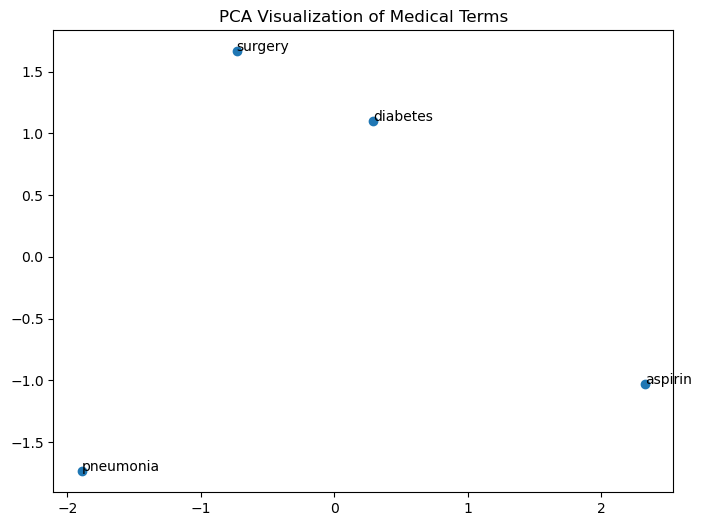

In [45]:
#PCA visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 选择关键词
keywords = ["pneumonia", "diabetes", "aspirin", "surgery", "blood_test"]

# 获取词向量
vectors = np.array([word2vec_model.wv[word] for word in keywords if word in word2vec_model.wv])

# PCA 降维到 2 维
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

# 标注关键词
for i, word in enumerate(keywords):
    if word in word2vec_model.wv:
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title("PCA Visualization of Medical Terms")
plt.show()


In [47]:
# cosine similarity 
from scipy.spatial.distance import cosine

def cosine_similarity(word1, word2, model):
    if word1 in model.wv and word2 in model.wv:
        sim = 1 - cosine(model.wv[word1], model.wv[word2])
        return sim
    else:
        return None

word_pairs = [("pneumonia", "infection"), ("aspirin", "ibuprofen"), ("surgery", "operation")]

for w1, w2 in word_pairs:
    sim = cosine_similarity(w1, w2, word2vec_model)
    if sim is not None:
        print(f" cosine similarity ({w1}, {w2}): {sim:.4f}")
    else:
        print(f"{w1} or {w2} not in corpus")


 cosine similarity (pneumonia, infection): 0.7387
 cosine similarity (aspirin, ibuprofen): 0.7186
 cosine similarity (surgery, operation): 0.5557
